In [1]:
%matplotlib inline
#
from LRGSG_package.LRGSG import *
from LRGSG_package.LRGSG_plots import imshow_colorbar_caxdivider, generate_maxpercdiff_colormap
from LRGSG_package.LRGSG_utils import move_to_rootf, width_interval, dv, boolean_overlap_fraction
from LRGSG_package.nx_patches import signed_spectral_layout, get_kth_order_neighbours
#
move_to_rootf(print_tf=True)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [2]:
sqlatt = Lattice2D(
    side1=32,
    geometry="squared",
    pflip=0.09
)
sqlatt.flip_random_fract_edges()

if not sqlatt.import_on:
    sqlatt.export_graph(MODE="pickle")
    sqlatt.export_adj_bin()


In [ ]:
vm = VoterModel(sqlatt, savedyn=True, simpref=10, runlang='C')

In [3]:
vm.init_s()
vm.run()

data/l2d_squared/graphs/N=1024/adj_sqLattice_p=0.09.bin: No such file or directory


In [4]:
idxs = np.where(
    np.array(
        [
            any(
                [
                    True if edges[2] < 0 else False
                    for edges in list(sqlatt.H.edges(i, data="weight"))
                ]
            )
            for i in sqlatt.H.nodes()
        ]
    )
    == True
)[0]
a = np.zeros((sqlatt.side1, sqlatt.side1))
a[np.unravel_index(idxs, (sqlatt.side1, sqlatt.side1))] = 1

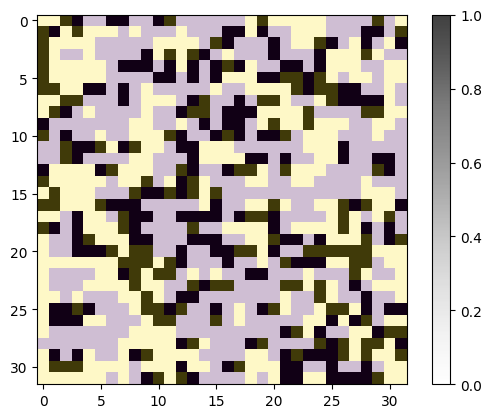

In [5]:
plt.imshow(vm.s_t[-1].reshape(sqlatt.side1, sqlatt.side1))
plt.imshow(a, alpha=0.75, cmap='Greys')
plt.colorbar()

(-1.0, 1.0)

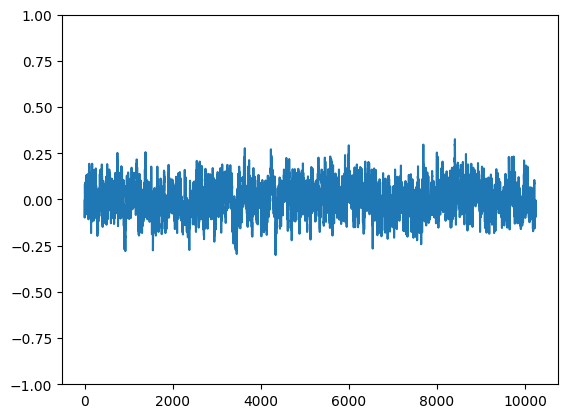

In [6]:
plt.plot([a.sum()/sqlatt.side1**2 for a in vm.s_t])
plt.ylim(-1, 1)

In [7]:
side = 64
pflip = 0.1
T_ising = 0.02
IMPORT = True
if IMPORT:
    args = {'import_on': True}
else:
    args = {}

# os.makedirs(f"data/l2d_sq_ising/graphs/N={side**2}/", exist_ok=True)
# os.makedirs(f"data/l2d_sq_ising/N={side**2}/", exist_ok=True)
sqlatt = Lattice2D(
    side1=side,
    geometry="squared",
    pflip=pflip,
    **args
)
# lrgsg = SignedLaplacianAnalysis(  #
#     system=sqlatt, 
#     initCond="all_1", 
#     t_steps=10, 
#     no_obs=200
# )
# # middlenode = theLattice.N//2+theLattice.side1//2
# # neg_weightsH = {(middlenode, middlenode+1): -1}
# # theLattice.flip_sel_edges(neg_weightsH, 'H')
# #
ising_dyn = IsingDynamics(
    system=sqlatt, 
    T=T_ising, 
    nstepsIsing=1000, 
    IsingIC="ground_state_0",
    MODE_RUN="C1", 
    NoClust = 5
)
if not sqlatt.import_on:
    sqlatt.flip_random_fract_edges()
    sqlatt.export_graph(MODE="pickle")
    sqlatt.export_adj_bin()


FileNotFoundError: [Errno 2] No such file or directory: 'data/l2d_squared/graphs/N=4096/sqLattice_p=0.1.pickle'

In [ ]:
ising_dyn.init_ising_dynamics()
ising_dyn.find_ising_clusters(
    import_cl = IMPORT
)
# ising_dyn.mapping_nodes_to_clusters()

Ising Clusters already computed.


In [ ]:
ising_dyn.id_string_isingdyn = ''
for i in range(100):
    ising_dyn.run()

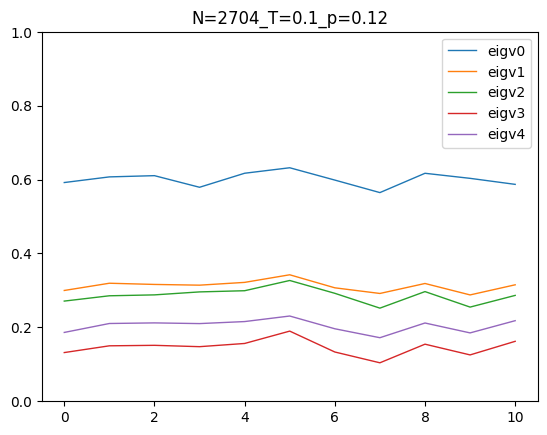

In [ ]:
for i in range(5):
    outclstr = f"data/l2d_squared/ising/N={sqlatt.N}/outcl{i}_sqLattice_p={pflip}_T={ising_dyn.T}_{ising_dyn.id_string_isingdyn}.txt"
    a = np.loadtxt(outclstr)
    plt.plot(np.abs(a[:, 0]), lw=1, label=f"eigv{i}")
plt.legend()
plt.ylim(0, 1)
tit = f"N={sqlatt.N}_T={ising_dyn.T:.3g}_p={sqlatt.pflip:.3g}"
plt.title(tit)
plt.savefig(f"data/plot/eigenv_{tit}.png", dpi=150)

In [ ]:
enepath = f"{sqlatt.isingpath}ene_{sqlatt.stdFname}_T={ising_dyn.T}_{ising_dyn.id_string_isingdyn}.bin"
ene = np.fromfile(enepath, dtype=float)
plt.plot(ene[:100], 'red')

FileNotFoundError: [Errno 2] No such file or directory: 'data/l2d_squared/ising/N=2704/ene_sqLattice_p=0.12_T=0.1_Z3aSuAbhVT.bin'

In [ ]:
ene

array([805., 814., 843., ...,   0.,   0.,   0.])

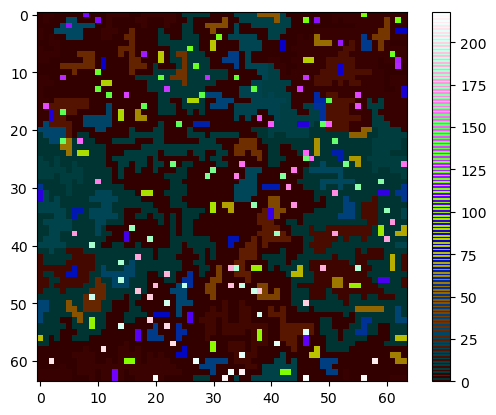

In [ ]:
def map_tuple_to_numeric(tuple_value):
    # You can use a weighted sum of the tuple elements as an example
    # Adjust the weights as needed based on your data
    weight = [0.1, 0.2, 0.5]
    numeric_value = np.sum(tuple_value * weight)
    return numeric_value

vfunc = np.vectorize(map_tuple_to_numeric)
max_diff_cmap = generate_maxpercdiff_colormap(ising_dyn.numIsing_cl, 2)
# Apply the mapping function to the entire 'result_array'
numeric_array = vfunc(ising_dyn.mapping)
plt.imshow(
    ising_dyn.mapping.astype(float),
    cmap=max_diff_cmap,
)
plt.colorbar()

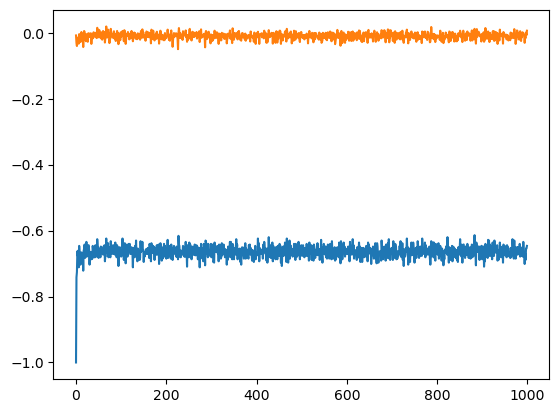

In [ ]:
plt.plot(np.array(ising_dyn.magnc1)/len(ising_dyn.Ising_clusters[0]))
plt.plot(np.array(ising_dyn.magn)/ising_dyn.system.N)
# plt.xscale('log')
# plt.yscale('log')

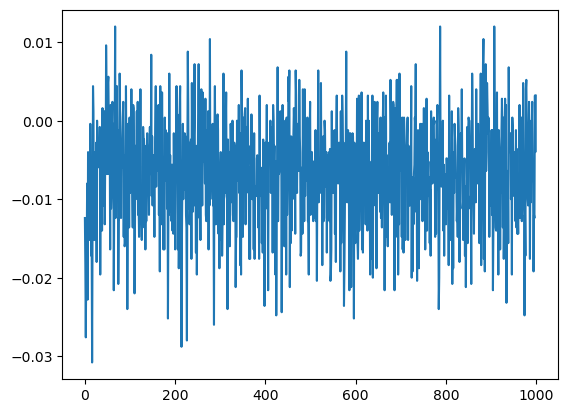

In [ ]:
plt.plot(np.array(ising_dyn.ene)/ising_dyn.system.N)

In [ ]:
np.mean(ising_dyn.magn)/ising_dyn.system.N, np.mean(ising_dyn.magnc1)/len(ising_dyn.Ising_clusters[0])

(-0.009768, -0.6641626016260163)

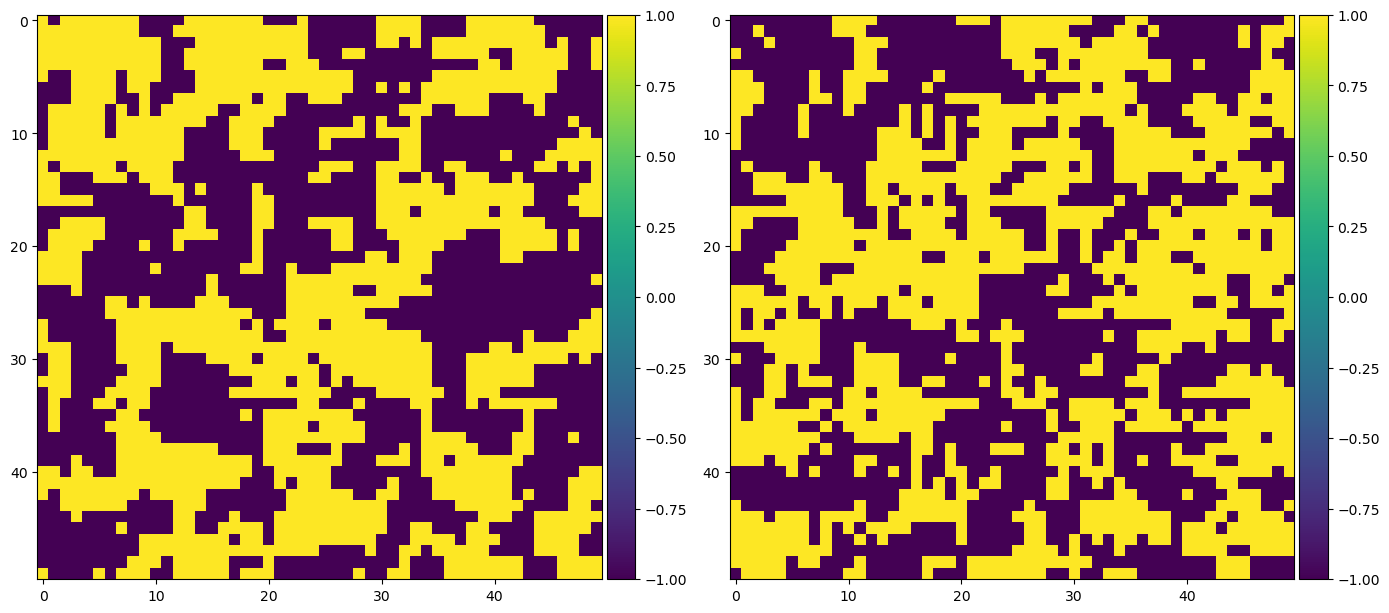

In [ ]:
bineigv = sqlatt.bin_eigV()
binmagn = ising_dyn.s
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))
im1 = ax[0].imshow(binmagn.reshape(sqlatt.side1, sqlatt.side2))
imshow_colorbar_caxdivider(im1, ax[0])
im2 = ax[1].imshow(bineigv.reshape(sqlatt.side1, sqlatt.side2))
imshow_colorbar_caxdivider(im2, ax[1])
fig.tight_layout()

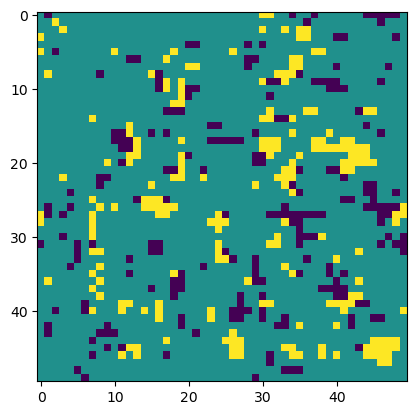

In [ ]:
plt.imshow(binmagn.reshape(sqlatt.side1, sqlatt.side2) + bineigv.reshape(sqlatt.side1, sqlatt.side2))

In [ ]:
boolean_overlap_fraction((bineigv > 0), (binmagn < 0))

0.8272

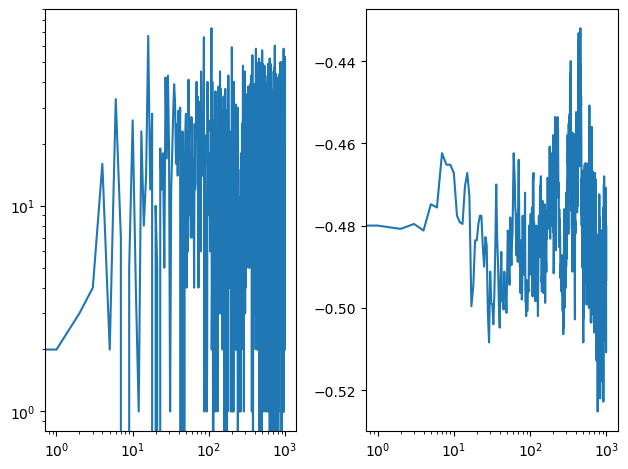

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(np.abs(dv(np.array(ising_dyn.ene))))
ax[0].set_yscale('log')
ax[0].set_xscale('log')
#
ax[1].plot(-np.array(ising_dyn.ene)/sqlatt.N)
ax[1].set_xscale('log')
fig.tight_layout()


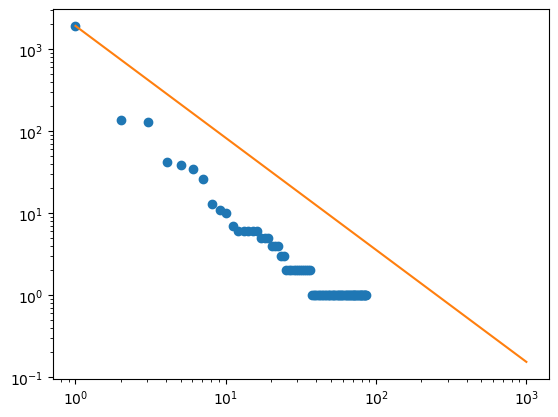

In [ ]:
# fare averages e controllare 2.05
# percolation clusters
# vedere per diverse p
# 
distr = np.unique(ising_dyn.mapping, return_counts=True)
zipf  = sorted(distr[1], reverse=True)
plt.plot(np.linspace(1, len(zipf)+1, num=len(zipf)), zipf, 'o')
plt.plot(np.logspace(0, 3), max(zipf)*(np.logspace(0, 2))**-2.05)
# plt.hist(distr[1])
plt.yscale('log')
plt.xscale('log')

In [ ]:
# bin_counts, bin_edges = np.histogram(lrgsg.mapping)
# bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

AttributeError: 'SignedLaplacianAnalysis' object has no attribute 'mapping'

In [ ]:
def map_tuple_to_numeric(tuple_value):
    # You can use a weighted sum of the tuple elements as an example
    # Adjust the weights as needed based on your data
    weight = [0.1, 0.2, 0.5]
    numeric_value = np.sum(tuple_value * weight)
    return numeric_value


vfunc = np.vectorize(map_tuple_to_numeric)
max_diff_cmap = generate_maxpercdiff_colormap(lrgsg.numIsing_cl, 2)
# Apply the mapping function to the entire 'result_array'
numeric_array = vfunc(lrgsg.mapping)
plt.imshow(
    lrgsg.mapping.astype(float),
    cmap=max_diff_cmap,
)
plt.colorbar()

AttributeError: 'SignedLaplacianAnalysis' object has no attribute 'numIsing_cl'

In [ ]:
#edge list
#indici di cluster
#inizializzazione stato
#

In [ ]:
idx0 = set(np.arange(0, lrgsg.system.N)) - set(sorted(lrgsg.biggestIsing_cl))
idx2Dcl = np.array([[i//lrgsg.system.side1, divmod(i, lrgsg.system.side2)[1]] for i in lrgsg.biggestIsing_cl])
idx2D = np.array([[i//lrgsg.system.side1, divmod(i, lrgsg.system.side2)[1]] for i in idx0])

In [ ]:
idx2D = idx2D[:, 0], idx2D[:, 1]
idx2Dcl = idx2Dcl[:, 0], idx2Dcl[:, 1]

In [ ]:

sum(lrgsg.magn_array.reshape(lrgsg.system.side1, lrgsg.system.side2)[idx2Dcl])/len(lrgsg.magn_array[lrgsg.biggestIsing_cl])

-0.7109227871939736

In [ ]:
lrgsg.magn_array[lrgsg.biggestIsing_cl]

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
a = lrgsg.magn_array.reshape(lrgsg.system.side1, lrgsg.system.side2)[idx2Dcl]

In [ ]:


lrgsg.magn_array.reshape(lrgsg.system.side1, lrgsg.system.side2)[idx2D] = 0

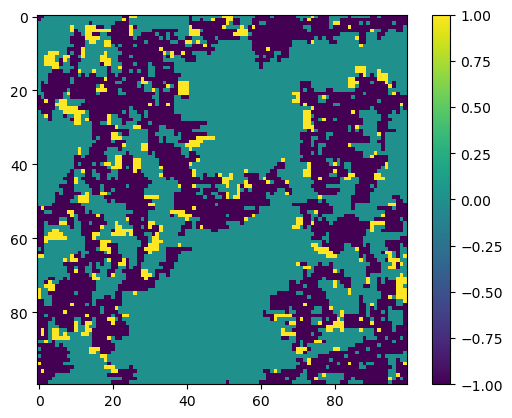

In [ ]:
plt.imshow(lrgsg.magn_array.reshape(lrgsg.system.side1, lrgsg.system.side2))
plt.colorbar()

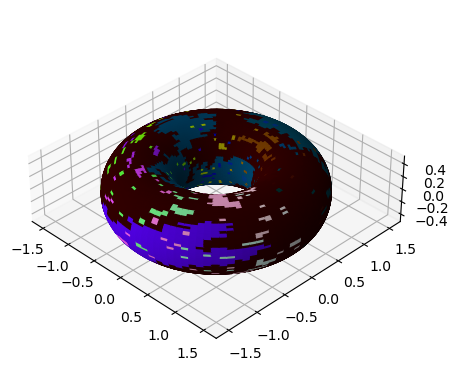

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib

# random colors
theta_dim, phi_dim = 100, 100
a = lrgsg.mapping.astype(float)

# Generating Torus Mesh
angle = np.linspace(0, 2 * np.pi, 100)
theta, phi = np.meshgrid(angle, angle)
r, R = .5, 1
X = (R + r * np.cos(phi)) * np.cos(theta)
Y = (R + r * np.cos(phi)) * np.sin(theta)
Z = r * np.sin(phi)

# compute the indexes
t = np.floor(theta / (2 * np.pi) * (theta_dim - 1)).astype(int)
p = np.floor(phi / (2 * np.pi) * (phi_dim - 1)).astype(int)
# extract the color value from the matrix
colors = a[t, p]
# apply a colormap to the normalized color values
norm = Normalize(vmin=colors.min(), vmax=colors.max())
cmap = max_diff_cmap#matplotlib.colormaps.get_cmap("viridis")
normalized_colors = cmap(norm(colors))

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, facecolors=normalized_colors)
ax.set_aspect("equal")
ax.view_init(elev=25., azim=-45)
plt.show()